In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx.readwrite import json_graph
import json
import pandas
import copy
import random

In [ ]:
def get_connected_graph(net):
  # Get a list of connected components
  components = list(nx.connected_components(net))
  # Find the largest connected component
  largest_component = max(components, key=len)
  # Create a new graph containing only the largest component
  net_largest = net.subgraph(largest_component)
  # print warning
  if not nx.is_connected(net_largest):
    print("Graph is not connected")
  return(net_largest)

def create_net(filename):
  adjmat = pd.read_csv(filename)
  adjmat.rename(columns=lambda x: x.replace('.', '|'), inplace=True)
  # Create an empty graph
  tmpG= nx.Graph()

  # Iterate over the rows and columns of the DataFrame to add edges with weights
  for row in range(len(adjmat)):
    # print(adjmat.iloc[row, 0])
    source = adjmat.iloc[row, 0]
    target = adjmat.iloc[row, 1]
    weight = adjmat.iloc[row, 2]

    # Skip diagonal and negative edges
    if source != target and weight > 0:
        tmpG.add_edge(source, target, weight=weight)

  # get connected graph:
  net = get_connected_graph(tmpG)
  return(net)

Creamos las redes con las funciones de arriba:
- Solo se almacenan los edges **positivos** de la componente conexa más grande (_largest connected component_ o LCC)

In [3]:
# KARLSSON
IGT_K = create_net("./networkFiles/karlsson_igt_edges.csv")
T2D_K = create_net("./networkFiles/karlsson_t2d_edges.csv")
CTL_K = create_net("./networkFiles/karlsson_control_edges.csv")

# QINJ
T2D_QJ = create_net("./networkFiles/qinj_t2d_edges.csv")
CTL_QJ = create_net("./networkFiles/qinj_control_edges.csv")

# IGT = Impaired Glucose Tolerance
# T2D = Type 2 Diabetes
# CTL = Control

Guardamos las cosas en dos diccionarios:
 - `disease_dict` para almacenar las condiciones que querremos aplicar a los gráficos (en este caso, color y estilo de línea)
 - `study_dict` para asignar estudio y condiciones a cada red 

In [5]:
IGT_col = "#35b779"
T2D_col = "#21918c"
CTL_col = "#440154"

In [7]:
disease_dict = {
            "IGT": {"color" : IGT_col, "linestyle" : "solid"},
            "T2D": {"color" : T2D_col, "linestyle" : "solid"},
            "CTL": {"color" : CTL_col, "linestyle" : "dashed"}}

In [8]:
study_dict = {"Karlsson" : {"IGT": IGT_K, "T2D" : T2D_K,
                            "CTL" : CTL_K},
              "QinJ" : {"T2D" : T2D_QJ, "CTL" : CTL_QJ}}

# Ataques a la red

## Ataque aleatorio
La función que utilizamos hace lo siguiente:
1. Selecciona un nodo aleatorio dentro de la lista de nodos
2. Elimina el nodo del grafo
3. Obtiene el tamaño del mayor componente conexo

Después visualizamos el tamaño de la mayor componente conexa en función del número de nodos eliminados.

In [9]:
def remove_random_node(g, n):
  lcc_sizes = []
  for i in range(n):
    node = random.choice(list(g.nodes()))
    g.remove_node(node)
    try:
      lcc_size = len(max(nx.connected_components(g), key=len))
    except:
      lcc_size = 0
    lcc_sizes.append(lcc_size)
  return(lcc_sizes)

In [ ]:
nreps = 100 # suelo hacer 100 o 1000
random.seed(505) 

Con esta función haremos las gráficas:

In [13]:
def plot_attack(net, plot_net, sd_net,
                       col = "black",
                       line = "solid",
                       lab = "Network"):
  x_vals_net = [i/net.order() for i in range(net.order())]
  net_rand_to_plot = np.array([i/net.order() for i in plot_net])
  net_rand_to_plot_sd = np.array([i/net.order() for i in sd_net])
  plt.plot(x_vals_net, net_rand_to_plot,
         label =lab, color = col, linestyle = line)
  plt.fill_between(x_vals_net,
                 net_rand_to_plot - net_rand_to_plot_sd,
                 net_rand_to_plot + net_rand_to_plot_sd,
                 color = col, alpha=0.2)


Hacemos una gráfica por estudio
- Como son ataques aleatorios, la gráfica dibuja la media de todos los valores y colorea el área correspondiente a la desviación típica.

Karlsson #################################
IGT
T2D
CTL


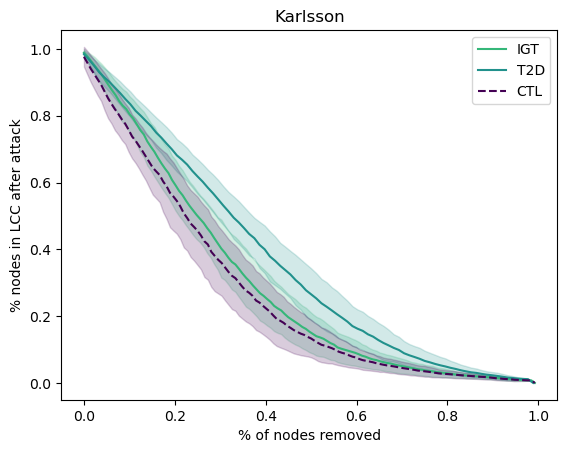

QinJ #################################
T2D
CTL


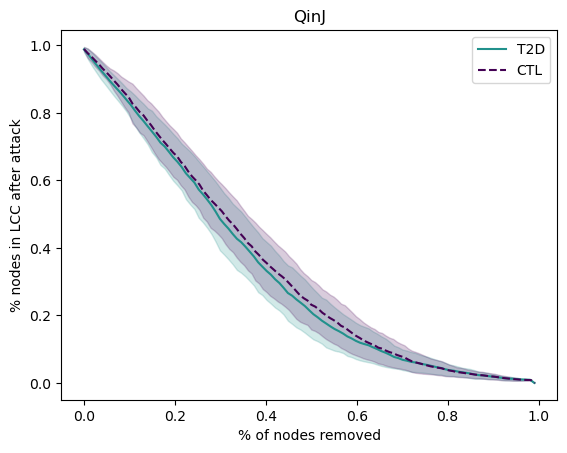

In [15]:
for study in study_dict:
  print(study, "#################################")
  for disease in study_dict[study]:
    print(disease)
    disease_lcc_sizes_random = []
    while len(disease_lcc_sizes_random) < nreps:
      net_kk = nx.Graph(study_dict[study][disease]) # copia para no cargarnos el original
      disease_lcc_sizes_random.append(remove_random_node(net_kk, net_kk.order()))

    arr_dis = np.array(disease_lcc_sizes_random)
    plot_dis = np.mean(arr_dis, axis = 0)
    sd_dis = np.std(arr_dis, axis = 0)

    plot_attack(study_dict[study][disease],
                plot_dis, sd_dis,
                disease_dict[disease]["color"],
                disease_dict[disease]["linestyle"],
                disease)
  plt.ylabel("% nodes in LCC after attack")
  plt.xlabel("% of nodes removed")
  plt.legend()
  plt.title(study)
  plt.show();

# Nodos a eliminar para desmontar 50% de la red

Calculamos cuántos nodos hacen falta para desmontar el 50% de la red en cada una de las aleatorizaciones y lo dibujamos en boxplots.

In [ ]:
nreps = 100
random.seed(505) 

In [23]:
threshold = .5 # proporcion de nodos que quedan

Ojo, aquí se están volviendo a hacer los ataques, podrían dar resultados distintos con respecto a la anterior (si vamos a mirar números). Habría que poner una semilla cada vez.

In [24]:
def remove_random_node(g, n):
  number_of_attacks = 0
  gOrder = g.order()
  lcc_size = g.order()
  for i in range(n):
    number_of_attacks += 1
    node = random.choice(list(g.nodes()))
    g.remove_node(node)
    try:
      lcc_size = len(max(nx.connected_components(g), key=len))
    except:
      lcc_size = 0
    if lcc_size/gOrder <= threshold:
      break

  return(number_of_attacks/gOrder)

In [25]:
threshold_dict = {}
for study in study_dict:
  threshold_dict[study] = {}
  for disease in study_dict[study]:
    disease_thresholds = []
    while len(disease_thresholds) < nreps:
      net_kk = nx.Graph(study_dict[study][disease])
      a50 = remove_random_node(net_kk, net_kk.order())
      disease_thresholds.append(a50)
    threshold_dict[study][disease] = disease_thresholds

In [26]:
import seaborn as sns
sns.set(style="whitegrid")
my_pal = { "IGT" : IGT_col, "T2D" : T2D_col,
          "CTL" : CTL_col}

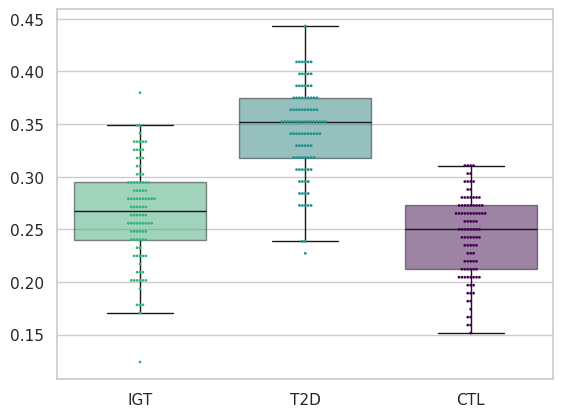

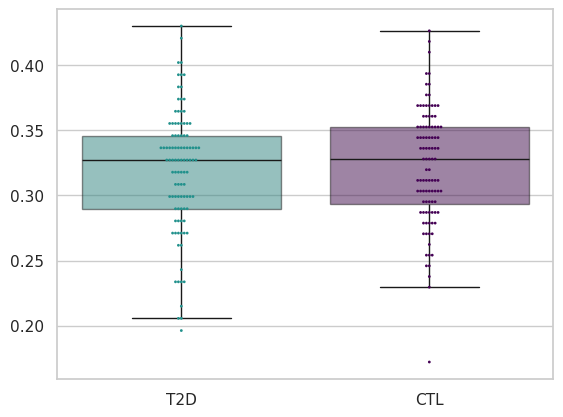

In [27]:
for study in threshold_dict:
  a50_dict = threshold_dict[study]
  df = pd.DataFrame(data = a50_dict)
  ax = sns.boxplot(data = df, showfliers = False, boxprops=dict(alpha=.5),
                 palette = my_pal)
  ax = sns.swarmplot(data = df,
                     size = 2,
                     palette = my_pal)
  plt.show()